<center>
    <img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/assets/logos/SN_web_lightmode.png" width="300" alt="cognitiveclass.ai logo"  />
</center>


# Variational Autoencoders


Estimated time needed: **25** minutes


Variational Autoencoders are a type of deep learning generative model. Once you train them on sufficiently large datasets and let them learn latent representations of the data, they can be used to draw faces, plot digits, produce music, and generate anything you can think of.

<img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML311-Coursera/images/vae_intro.jpg" width=60%>


In this lab, we will study the architecture of VAEs. We will build a VAE ourselves using Keras and train the model on the MNIST digits dataset, so that they can be used to generate new images of digits.


## **Table of Contents**

<ol>
    <li><a href="https://#Objectives">Objectives</a></li>
    <li>
        <a href="https://#Setup">Setup</a>
        <ol>
            <li><a href="https://#Installing-Required-Libraries">Installing Required Libraries</a></li>
            <li><a href="https://#Importing-Required-Libraries">Importing Required Libraries</a></li>
            <li><a href="https://#Defining-Helper-Functions">Defining HelperFunctions<a></li>
        </ol>
    </li>
    <li>
        <a href="https://#Dataset">Prepare Dataset</a>
    </li>  
    <li>
        <a href="https://#Variational-Autoencoder">Variational Autoencoder</a>
    </li>
        <li>
        <a href="https://#Encoder Part">Encoder Part</a>
    </li>
     <li>
        <a href="https://#Decoder Part">Decoder Part</a>
    </li>
         <li>
        <a href="https://#Loss-function">Loss function </a>
    </li>
      <li>
        <a href="https://#Putting-it all together">Putting it all together  </a>
    </li>
    <li><a href="https://#Training the VAE">Training the VAE</a></li>

</ol>


## Objectives

After completing this lab you will be able to:

*   Understand the architecture of a Variational Autoencoder
*   Build and train Variational Autoencoder in Keras


***


## Setup


For this lab, we will be using the following libraries:

*   [`pandas`](https://pandas.pydata.org/?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMML0187ENSkillsNetwork31430127-2021-01-01) for managing the data.
*   [`numpy`](https://numpy.org/?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMML0187ENSkillsNetwork31430127-2021-01-01) for mathematical operations.
*   [`sklearn`](https://scikit-learn.org/stable/?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMML0187ENSkillsNetwork31430127-2021-01-01) for machine learning and machine-learning-pipeline related functions.
*   [`seaborn`](https://seaborn.pydata.org/?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMML0187ENSkillsNetwork31430127-2021-01-01) for visualizing the data.
*   [`matplotlib`](https://matplotlib.org/?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMML0187ENSkillsNetwork31430127-2021-01-01) for additional plotting tools.


### Installing Required Libraries

The following required libraries are pre-installed in the Skills Network Labs environment. However, if you run these notebook commands in a different Jupyter environment (like Watson Studio or Ananconda), you will need to install these libraries by removing the `#` sign before `!mamba` in the code cell below.


In [1]:
# All Libraries required for this lab are listed below. The libraries pre-installed on Skills Network Labs are commented.
# !mamba install -qy pandas==1.3.4 numpy==1.21.4 seaborn==0.9.0 matplotlib==3.5.0 scikit-learn==0.20.1
# Note: If your environment doesn't support "!mamba install", use "!pip install"

Run the following upgrade and then **RESTART YOUR KERNEL**. Make sure the version of tensorflow imported below is **no less than 2.9.0**.


In [2]:
%%capture
!pip3 install --upgrade tensorflow

### Importing Required Libraries

*We recommend you import all required libraries in one place (here):*


In [3]:
# You can use this section to suppress warnings generated by your code:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn
warnings.filterwarnings('ignore')

import os
import numpy as np

# Import the keras library
import tensorflow as tf
print(tf.__version__)
from tensorflow import keras
from tensorflow.keras import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense,Layer,Reshape,Conv2DTranspose
from tensorflow.python.client import device_lib
from keras.layers import Multiply, Add
from keras import backend as K

from numpy import random

from matplotlib import pyplot as plt

2025-06-18 17:25:47.485446: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-06-18 17:25:47.687756: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-06-18 17:25:47.692867: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2025-06-18 17:25:47.692892: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore 

2.11.0


### Defining Helper Functions


In [4]:
def plot_label_clusters(model, data, labels):
    # display a 2D plot of the digit classes in the latent space
    z_mean, _, _ =encoder.predict(data)
    plt.figure(figsize=(8, 6))
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c=labels)
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.show()

## Preparing the Dataset


We load the MNIST handwritten digit dataset:


In [5]:
# Import data
(X_train, y_train), (_, _) = keras.datasets.mnist.load_data()

11490434/11490434 [==============================] - 0s 0us/step


There are 60000 $28 \times 28$ images in the training set:


In [6]:
X_train.shape, y_train.shape

((60000, 28, 28), (60000,))

Let's look at the unique labels of the digits that we want to predict:


In [7]:
np.unique(y_train)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

We will reshape the training set to $60000 \times 28 \times 28 \times 1$ to work with convolutions. 1 indicates that the input images only have one channel, that is: grayscale images.


In [8]:
print(f"Before reshaping, X_train has a shape of: {X_train.shape}")

X_train = X_train.reshape((X_train.shape[0],X_train.shape[1],X_train.shape[2],1))
print(f"After reshaping, X_train has a shape of: {X_train.shape}")

Before reshaping, X_train has a shape of: (60000, 28, 28)
After reshaping, X_train has a shape of: (60000, 28, 28, 1)


We cast the data type of `X_train` to `tf.float32` and normalize its values to range from 0 to 1:


In [9]:
X_train = tf.cast(X_train, tf.float32)
X_train = X_train/255.0

2025-06-18 17:26:39.361949: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2025-06-18 17:26:39.362019: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2025-06-18 17:26:39.362066: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (jupyterlab-mahmud156248): /proc/driver/nvidia/version does not exist
2025-06-18 17:26:39.362820: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


We convert the tensors to a `tf.data.Dataset` object.


In [10]:
dataset=tf.data.Dataset.from_tensor_slices(X_train)
dataset

<TensorSliceDataset element_spec=TensorSpec(shape=(28, 28, 1), dtype=tf.float32, name=None)>

We can plot five random samples from the training set:


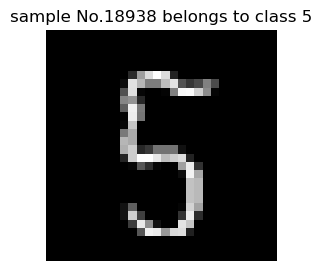

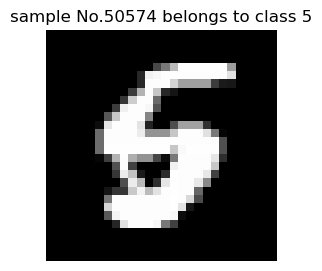

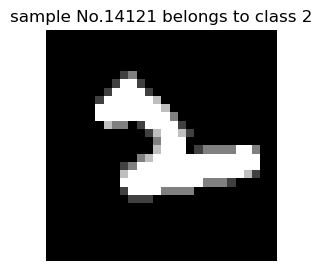

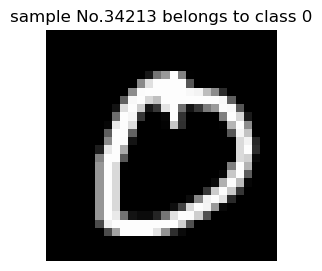

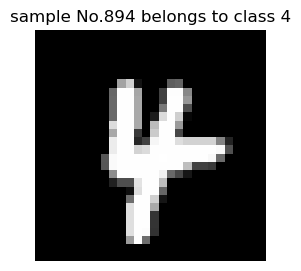

In [11]:
for r in random.randint(0, 59999, size=5, dtype=int):
    
    plt.figure(figsize=(3,3))
    plt.imshow(X_train[r,:,:,0],cmap="gray")
    plt.title("sample No.{} belongs to class {}".format(r,y_train[r]))
    plt.axis("off")

## Variational Autoencoder

In a nutshell, the architecture of a VAE is similar to that of a standard Autoencoder such that it consists of an encoder and a decoder, both of which are trained to minimize the reconstruction error between the original data $X$ and the encoded-decoded data $\hat X$.

The training samples $X$ are passed to the encoder to generate samples $\boldsymbol z$, which are mappings of $X$ in the latent space.  The decoder then uses $\boldsymbol z$ to generate the most likely reconstruction $\hat X$.

At this point, a natural question that comes in mind is, how do we use VAEs to generate meaningful content? You might think that if we train a VAE on images, then we can use it to generate new images. However, since it's difficult to regularize what happens to our encoder output in the latent space, we can't be sure that the encoder will organize information in the latent space in a way that the decoder can easily take that information and generates content that seems reasonable.

Hence, in order to be able to use the VAE for meaningful generative purposes, we need to introduce some regularization into the latent space. As shown in the diagram below, **instead of mapping the input to a single point in the latent space, we encode it as a normal distribution by returning the mean and standard deviation of the distribution**. By doing so, the decoder would be able to use the regularized information to construct new content.

In the following sections, we will build a VAE by following the architecture in the illustrative diagram below.


 <center>
    <img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML311-Coursera/labs/autoencoder.png"" width="800" alt="computer components"  />
<center>


## Encoder Part

We build the encoder part by breaking it up into three smaller parts.

The **first part** of the encoder consists of several fully connected layers, as shown in the picture below, which encodes the high-dimensional input; For our implementation, we will use two **convolution layers** since we want the model to learn the image data using convolutions.

<center><img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML311-Coursera/labs/encoder.png" width="30%" alt="computer components"/></center>


Here is the code for building the first part of the encoder. The `encoder_output` that comes out of the convolution layers is denoted as $\boldsymbol z^2$.


In [12]:
encoder_input= keras.Input(shape=(28, 28, 1))
x = Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_input)
x = Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
x = Flatten()(x)
encoder_output = Dense(16, activation="relu")(x)

The **second part** of the encoder represents a normal distribution over the latent space that takes the `encoder_output` and gives you the probability of it belonging to the distribution.

The mean and standard deviation of the normal distribution will be learned and then used to calculate the log-likelihood for optimization purposes.


 <center>
    <img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML311-Coursera/labs/mean_var.png" width="400" alt="computer components"  />
<center>


To implement the second part, we create **two Dense layers** in parallel for the model to learn the **mean** and **log variance** respectively; We want the model to learn the log variance instead of the variance because it brings more stability and ease of training. The detailed reason is as follows:

*   By definition, $\sigma$ is a non-negative real number. To enforce this, we would need to use the ReLU activation to obtain such a value, but the gradient is not well defined around zero.
*   Besides, since we typically apply normalization methods in model training, the data values range from 0 to 1, which means the standard deviation of those values is also very small. This adds a burden to the optimization process and causes numerical instabilities as the gradients flowing in the backpropagation will contain floating points.

Note that we can convert the log variance to the standard deviation using the exponential function. Here is the code for building the second part:


In [13]:
latent_dim = 2

# Dense layer to learn the mean
mean = Dense(latent_dim, name="mean")(encoder_output)
# Dense layer to learn the log variance
log_var = Dense(latent_dim, name="z_log_var")(encoder_output)

# sigmia is calculated from log variance
sigma = tf.exp(0.5 * log_var)

Here comes the **third part** of the encoder, where we sample a point from the learned distribution in the latent space. The sampled point will later be decoded by the decoder to generate new content.

The following diagram illustrates the random sampling:

<center>
    <img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML311-Coursera/labs/repramateriztion.png" width="400" alt="computer components"  />
<center> 


The sampled point, denoted by $\boldsymbol z^5$ in the diagram, comes from a normal distribution with mean $\mu$ and standard deviation $\sigma$, with some random noise $\epsilon$.


In [14]:
# random normal noise 
epsilon = K.random_normal(shape = (tf.shape(mean)[0], tf.shape(mean)[1]))

Due to the random sampling of $\boldsymbol z^5$, we use the [Reparameterization Trick](https://gregorygundersen.com/blog/2018/04/29/reparameterization/?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkML311Coursera35714171-2022-01-01) $ z = \mu + \sigma \odot \epsilon$, which allows the VAE to backpropagate through a random node.


In [15]:
#z = mean + sigma * epsilon 
 
z_eps = Multiply()([sigma, epsilon])
z = Add()([mean, z_eps])

The encoder will output the `mean` and `log_var` of the learned distribution as well as the sampled point `z`. Now, we create the complete encoder network by chaining the `encoder_input` and the `outputs`:


In [16]:
encoder = Model(encoder_input, outputs = [mean, log_var, z], name = 'encoder')
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 14, 14, 32)   320         ['input_1[0][0]']                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 7, 7, 64)     18496       ['conv2d[0][0]']                 
                                                                                                  
 flatten (Flatten)              (None, 3136)         0           ['conv2d_1[0][0]']               
                                                                                            

## Decoder Part

The decoder part of a VAE is the same as that of a regular Autoencoder. To upsample the output from the encoder, we can use the Keras Sequential model API to group a stack of Dense layers and Transpose Convolution layers together.

<center>
    <img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML311-Coursera/labs/decoder.png" width="400" alt="computer components"  />
<center>


In [17]:
latent_dim=2
decoder=Sequential()

decoder.add(keras.Input(shape=(latent_dim,))) # input dimension is 2
decoder.add(Dense(7 * 7 * 64, activation="relu"))
decoder.add(Reshape((7, 7, 64)))
decoder.add(Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same"))
decoder.add(Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same"))
decoder.add(Conv2DTranspose(1, 3, activation="sigmoid", padding="same"))
decoder.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 3136)              9408      
                                                                 
 reshape (Reshape)           (None, 7, 7, 64)          0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 14, 14, 64)       36928     
 nspose)                                                         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 28, 28, 32)       18464     
 ranspose)                                                       
                                                                 
 conv2d_transpose_2 (Conv2DT  (None, 28, 28, 1)        289       
 ranspose)                                                       
                                                        

## Loss Function


We include the **reconstruction loss**, which compares the output of the VAE to the original input. In this case, we use the mean square error. We also include a **regularization term**, which regularizes the organization of the latent space by making the distribution learned by the encoder close to a standard normal distribution. The regularization is enforced using the Kullback–Leibler divergence that compares two distributions.


In [18]:
# make loss function 

#reconstruction_loss
def reconstruction_loss(y, y_hat):
    return tf.reduce_mean(tf.square(y - y_hat))


#Kullback–Leibler divergence encoder loss
def kl_loss(mu, log_var):
    loss = -0.5 * tf.reduce_mean(1 + log_var - tf.square(mean) - tf.exp(log_var))
    return loss

# add two losses 
def vae_loss(y_true, y_hat, mu, log_var):
    return reconstruction_loss(y_true, y_hat) + (1 / (64*64)) * kl_loss(mean, log_var)


## Putting it all Together


We combine the Encoder and Decoder to create a VAE, and append the regularization term to the model:


In [19]:
# encoder returns mean and log variance of the normal distribution,
# and a sample point z
mean, log_var, z = encoder(encoder_input)

# decoder decodes the sample z 
reconstructed = decoder(z)

model = Model(encoder_input, reconstructed, name ="vae")
loss = kl_loss(mean, log_var)
model.add_loss(loss)
model.summary()

Model: "vae"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 encoder (Functional)           [(None, 2),          69076       ['input_1[0][0]']                
                                 (None, 2),                                                       
                                 (None, 2)]                                                       
                                                                                                  
 sequential (Sequential)        (None, 28, 28, 1)    65089       ['encoder[0][2]']                
                                                                                                

## Training the VAE

We now train the model. After each epoch, we input random noise <code>z</code> into the decoder. We will see for each epoch, the decoder output will look more and more like a digit.

We also output the values for the latent space z for all the different digits in our dataset, color coded according to class. We see that for each iteration, the samples appeared more clustered.


Samples generated by decoder after 0 epoch(s): 
1/1 [==============================] - 0s 437ms/step


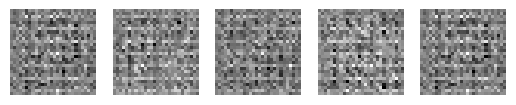

2D latent representations of the training data produced by encoder after 0 epoch(s): 
1875/1875 [==============================] - 7s 4ms/step


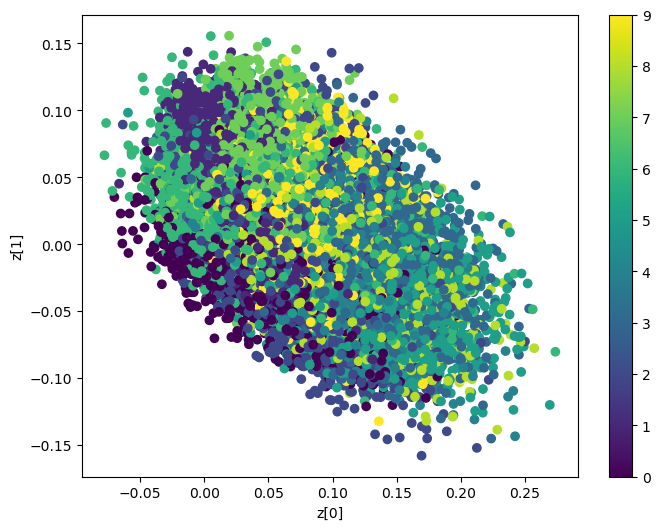

Epoch: 0 - Step: 599 - MSE loss: 0.06411722 - KL loss: 0.057767164
Samples generated by decoder after 1 epoch(s): 
1/1 [==============================] - 0s 29ms/step


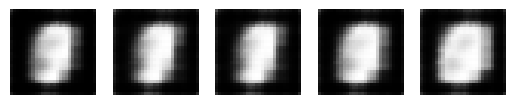

2D latent representations of the training data produced by encoder after 1 epoch(s): 
1875/1875 [==============================] - 7s 4ms/step


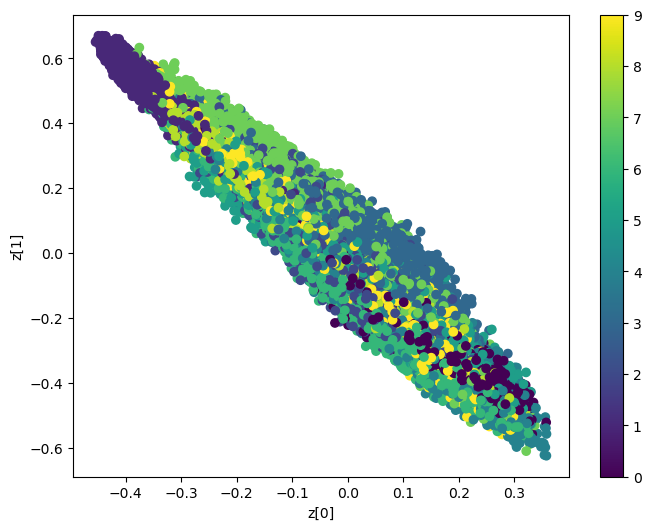

Epoch: 1 - Step: 599 - MSE loss: 0.06282091 - KL loss: 0.15974484
Samples generated by decoder after 2 epoch(s): 
1/1 [==============================] - 0s 27ms/step


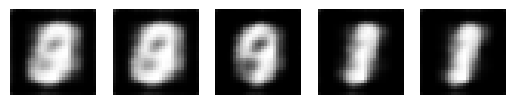

2D latent representations of the training data produced by encoder after 2 epoch(s): 
1875/1875 [==============================] - 7s 4ms/step


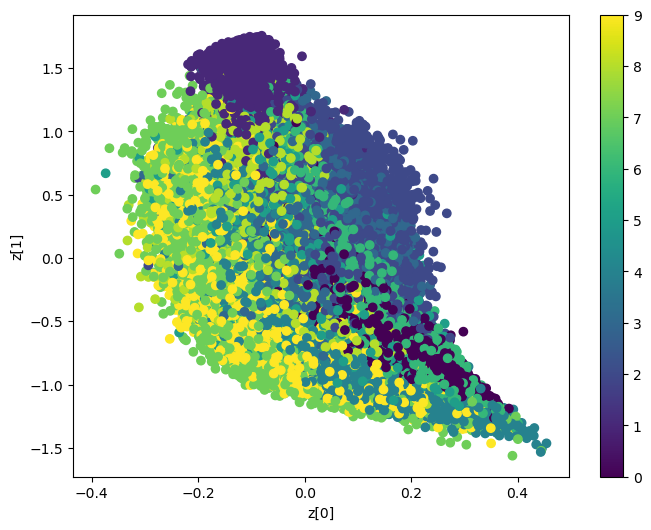

Epoch: 2 - Step: 599 - MSE loss: 0.06347309 - KL loss: 0.2468466
Samples generated by decoder after 3 epoch(s): 
1/1 [==============================] - 0s 30ms/step


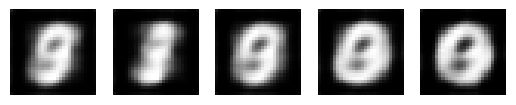

2D latent representations of the training data produced by encoder after 3 epoch(s): 
1875/1875 [==============================] - 7s 4ms/step


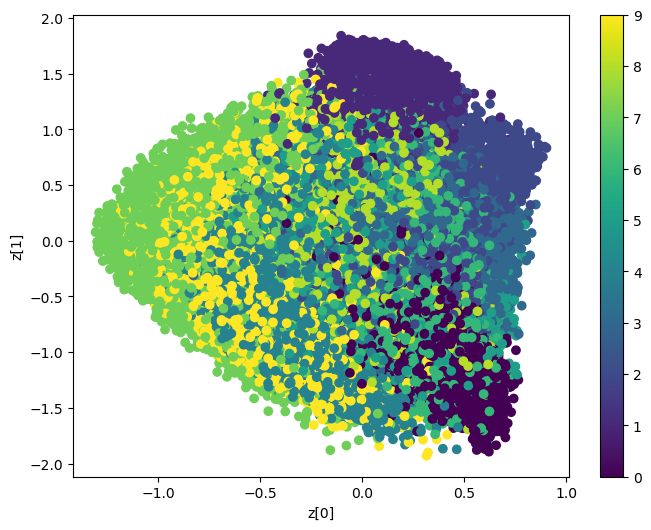

Epoch: 3 - Step: 599 - MSE loss: 0.06479684 - KL loss: 0.31087825
Samples generated by decoder after 4 epoch(s): 
1/1 [==============================] - 0s 47ms/step


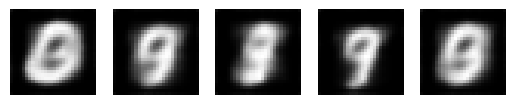

2D latent representations of the training data produced by encoder after 4 epoch(s): 
1875/1875 [==============================] - 7s 4ms/step


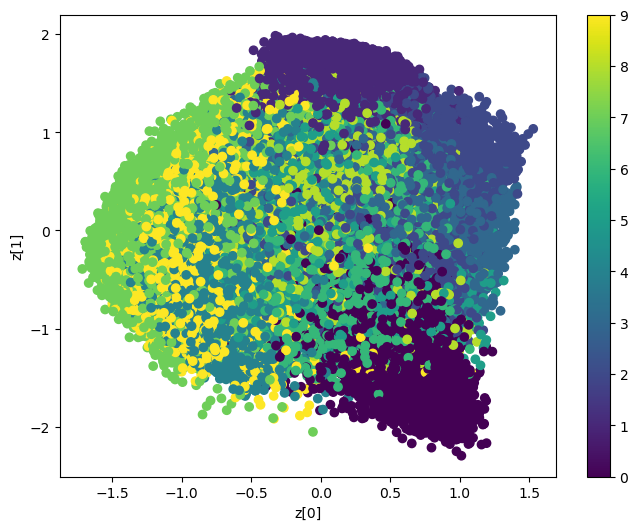

Epoch: 4 - Step: 599 - MSE loss: 0.063124105 - KL loss: 0.39572227


In [20]:
#loss
mse_losses = []
kl_losses = []
# optimizer 
optimizer =  tf.keras.optimizers.Adam(learning_rate = 0.0002, beta_1 = 0.5, beta_2 = 0.999 )
epochs = 5

for epoch in range(epochs):
    
    print(f"Samples generated by decoder after {epoch} epoch(s): ")
    
    #random noise
    z = tf.random.normal(shape = (5, latent_dim,))

    # input random noise into the decoder
    xhat = decoder.predict(z)
    
    # plot the decoder output
    plt.figure()
    for i in range(5):
        plt.subplot(1,5,i+1)
        plt.imshow(xhat[i,:,:,0],cmap="gray")
        plt.axis("off")
    plt.show()

    print(f"2D latent representations of the training data produced by encoder after {epoch} epoch(s): ")
    plot_label_clusters(encoder, X_train, y_train)


    # training steps
    for (step, training_batch) in enumerate(dataset.batch(100)):
        with tf.GradientTape() as tape:

            # model output
            reconstructed = model(training_batch)

            y_true = tf.reshape(training_batch, shape = [-1])
            y_pred = tf.reshape(reconstructed, shape = [-1])

            # calculate reconstruction loss
            mse_loss = reconstruction_loss(y_true, y_pred)
            # calculate KL divergence
            kl = sum(model.losses)

            kl_losses.append(kl.numpy())
            mse_losses.append(mse_loss .numpy())

            # total loss
            train_loss = 0.01 * kl + mse_loss

            grads = tape.gradient(train_loss, model.trainable_variables)
            optimizer.apply_gradients(zip(grads, model.trainable_variables))
         
    print("Epoch: %s - Step: %s - MSE loss: %s - KL loss: %s" % (epoch, step, mse_loss.numpy(), kl.numpy()))
  

We plot the reconstruction loss and Kullback–Leibler divergence against the number of training iterations, we can see that they are both decreasing.


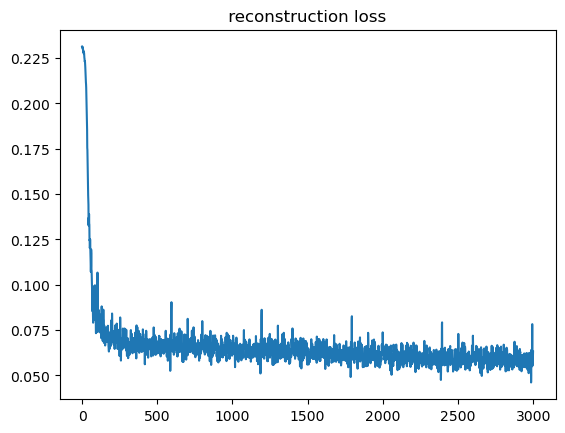

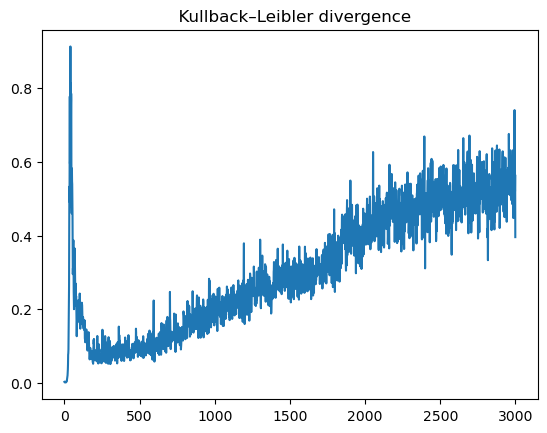

In [21]:
plt.plot(mse_losses)
plt.title(" reconstruction loss ")
plt.show()
plt.plot(kl_losses)
plt.title("  Kullback–Leibler divergence")
plt.show()

Now that our VAE has been trained, we can use its decoder network to generate some samples. Let's see if our decoder can do a good job in generating artificial images that look like digits!


1/1 [==============================] - 0s 28ms/step


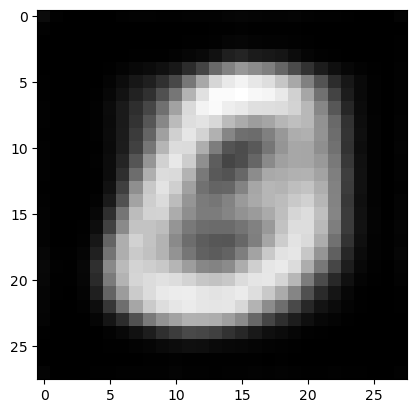

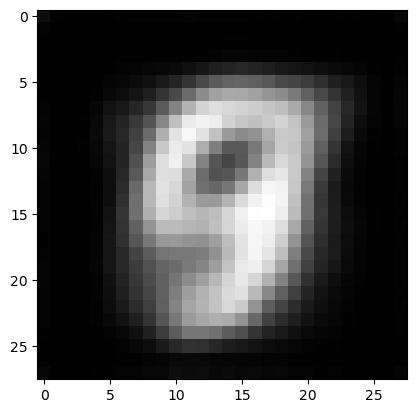

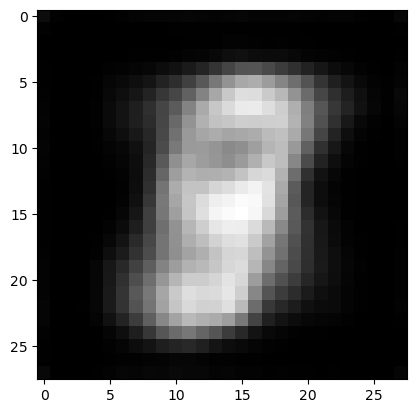

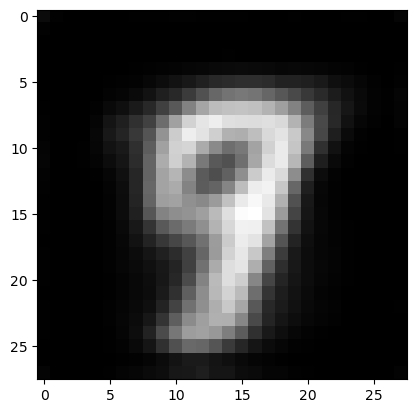

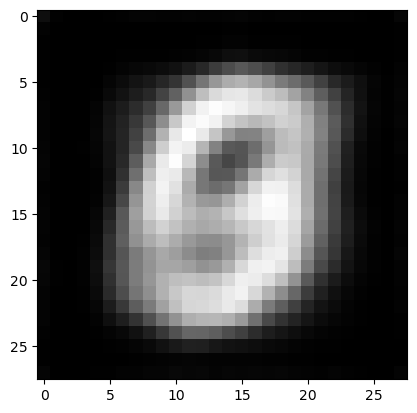

In [22]:
xhat = decoder.predict(z)

for i in range(5):
    plt.imshow(xhat[i,:,:,0],cmap="gray")
    plt.show()

We can also visualize the final latent representations of the training data produced by the trained encoder on a 2D plot, colored by classes.


In [ ]:
plot_label_clusters(encoder, X_train, y_train)

 846/1875 [============>.................] - ETA: 3s

## Congratulations! You have completed this lab.


## Authors


[Joseph Santarcangelo](https://www.linkedin.com/in/joseph-s-50398b136/?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkML311Coursera35714171-2022-01-01) has a PhD in Electrical Engineering, his research focused on using machine learning, signal processing, and computer vision to determine how videos impact human cognition. Joseph has been working for IBM since he completed his PhD.

[Roxanne Li](https://www.linkedin.com/in/roxanne-li/?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkML311Coursera35714171-2022-01-01) is a Data Science intern at IBM Skills Network, entering level-5 study in the Mathematics & Statistics undergraduate Coop program at McMaster University.


## Change Log


| Date (YYYY-MM-DD) | Version | Changed By | Change Description      |
| ----------------- | ------- | ---------- | ----------------------- |
| 2022-09-14        | 0.1     | Joseph S.  | Created Lab             |
| 2022-09-19        | 0.1     | Roxanne Li | Reviewed and edited lab |


Copyright © 2022 IBM Corporation. All rights reserved.
